# Distribution by long tail candlestick - Analytics

### Import Library

In [43]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [44]:
import os
from pathlib import Path
notebook_path = os.getcwd()
current_dir = Path(notebook_path)
csv_file = str(current_dir) + '/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [45]:
data = dataset.copy()

In [46]:
# data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-10-01 00:00:00')]
data = data[data.index > '2020-11-01 00:00:00']

In [47]:
long_tail_length = 1.9
data['tail'] = data.apply(lambda r: max(min(r['Close'], r['Open']) - r['Low'], r['High'] - max(r['Close'], r['Open'])), axis=1)
data['is_longtail'] = data.apply(lambda r: True if r['tail'] > long_tail_length else False, axis=1)

In [48]:
data[data.is_longtail == True]

,Open,High,Low,Close,Volume,tail,is_longtail
Date,,,,,,,
2020-11-03 14:00:00,906.1,908.5,906.1,906.3,6841,2.2,True
2020-11-04 14:20:00,915.2,915.2,910.2,912.6,8136,2.4,True
2020-11-16 13:10:00,932.0,934.7,930.3,931.3,4468,2.7,True
2020-11-16 13:50:00,929.0,929.4,925.5,928.2,5747,2.7,True
2020-11-16 14:05:00,929.5,930.2,926.2,929.0,6304,2.8,True
...,...,...,...,...,...,...,...
2025-02-03 09:10:00,1324.8,1326.0,1322.7,1325.5,3600,2.1,True
2025-02-04 09:00:00,1325.5,1327.7,1324.2,1325.5,11561,2.2,True
2025-02-07 13:40:00,1343.9,1347.4,1343.8,1345.3,14175,2.1,True


## Group labeling

In [49]:
## 1 is min, 2 is max, 0 is not min not max
groups = []
for i, row in data.iterrows():
    if row['is_longtail']:
        current_date = row.name.strftime('%Y-%m-%d ').format()
        current_time = row.name
        data_to_end_day = data[(data.index >=  current_date + ' 09:00:00') & (data.index < current_date + ' 14:30:00')]
        max_High = data_to_end_day['High'].max()
        min_Low = data_to_end_day['Low'].min()
        #
        if row['High'] == max_High:
            groups.append(2)
        elif row['Low'] == min_Low:
            groups.append(1)
        else:
            groups.append(0)
    else:
        groups.append(0)

In [50]:
data['group'] = groups

In [51]:
data[(data.is_longtail == True) & (data.group == 0)]

,Open,High,Low,Close,Volume,tail,is_longtail,group
Date,,,,,,,,
2020-11-03 14:00:00,906.1,908.5,906.1,906.3,6841,2.2,True,0
2020-11-04 14:20:00,915.2,915.2,910.2,912.6,8136,2.4,True,0
2020-11-16 13:10:00,932.0,934.7,930.3,931.3,4468,2.7,True,0
2020-11-16 13:50:00,929.0,929.4,925.5,928.2,5747,2.7,True,0
2020-11-16 14:05:00,929.5,930.2,926.2,929.0,6304,2.8,True,0
...,...,...,...,...,...,...,...,...
2025-01-10 13:30:00,1307.6,1308.1,1305.6,1307.6,6362,2.0,True,0
2025-01-14 13:40:00,1290.5,1290.5,1286.0,1287.9,9641,1.9,True,0
2025-02-03 09:10:00,1324.8,1326.0,1322.7,1325.5,3600,2.1,True,0


## 3. Time analytics

In [60]:
df3 = data[data.is_longtail == True].copy()
df3['hour'] = df3.index.hour

<Axes: xlabel='hour'>

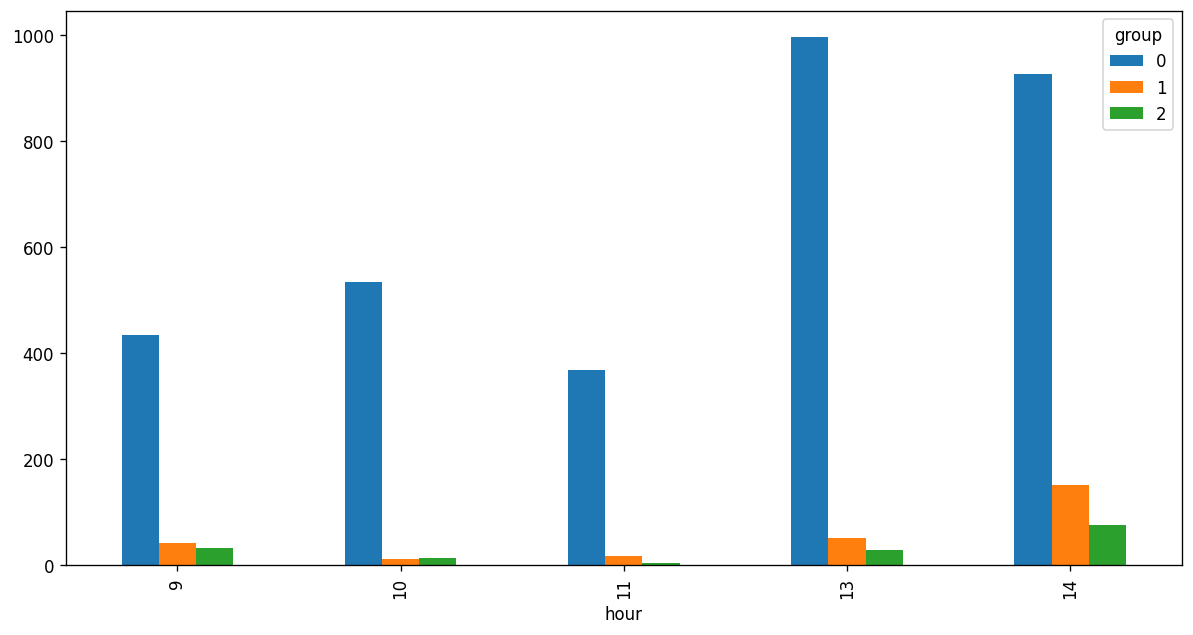

In [62]:
group_by_hour = df3.groupby(['hour', 'group'])['hour'].count().rename({'hour': 'count'})
group_by_hour.unstack().plot.bar()

## 2.  Tail on body analytics

In [52]:
df2 = data[data.is_longtail == True].copy()
df2['body'] = abs(df2['Close'] - df2['Open'])
df2['body_on_tail'] = df2['body'] / df2['tail']
df2['body_on_tail'] = round(df2['body_on_tail'], 1)

In [53]:
# quantile signal data
deq_low = df2["body_on_tail"].quantile(0.01)
deq_high  = df2["body_on_tail"].quantile(0.99)
df2 = df2[(df2["body_on_tail"] < deq_high) & (df2["body"] > deq_low)]

<Axes: xlabel='body_on_tail'>

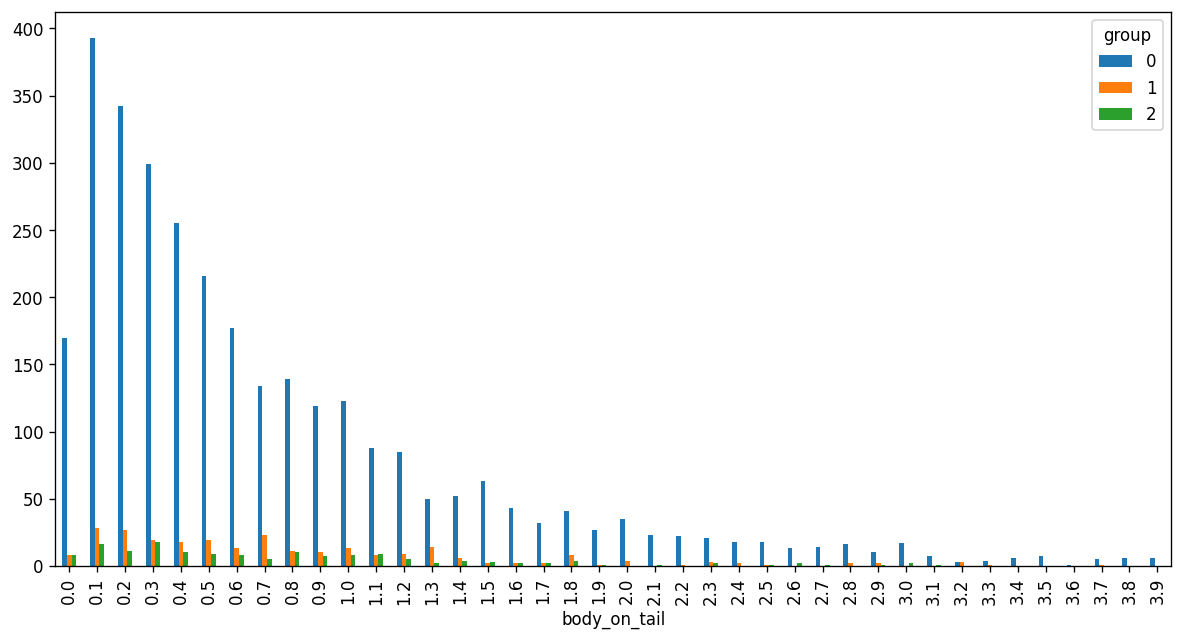

In [54]:
group_by_body_on_tail = df2.groupby(['body_on_tail', 'group'])['body_on_tail'].count().rename({'body_on_tail': 'count'})
group_by_body_on_tail.unstack().plot.bar()

 ## 1. Body analytics

In [55]:
df1 = data[data.is_longtail == True].copy()
df1['body'] = abs(df1['Close'] - df1['Open'])
df1['body'] = round(df1['body'], 1)

In [56]:
# quantile signal data
deq_low = df1["body"].quantile(0.01)
deq_high  = df1["body"].quantile(0.99)
df1 = df1[(df1["body"] < deq_high) & (df1["body"] > deq_low)]

<Axes: xlabel='body'>

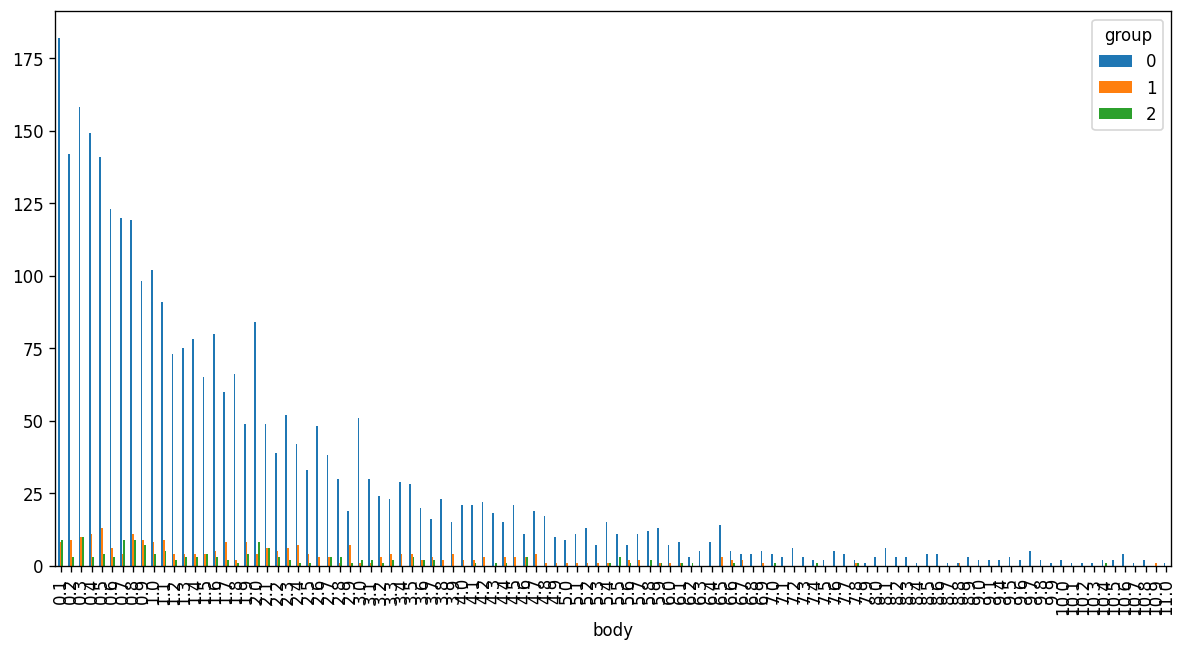

In [57]:
group_by_body = df1.groupby(['body', 'group'])['body'].count().rename({'body': 'count'})
group_by_body.unstack().plot.bar()